In [1]:
import pandas  as pd
import numpy as np
from sklearn.utils import shuffle
from sklearn import datasets
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report 

---
# **Decision Tree Classififer**

In [2]:
class DecisionTreeClassifier:
    def __init__(self, max_depth=10):
        self.max_depth = max_depth
        self.n_classes = None
        self.n_features = None
        self.tree = None

    def fit(self, X, y):
        self.n_classes = len(set(y))
        self.n_features = X.shape[1]
        self.tree = self._grow_tree(X, y)


    def _gini(self, y):
        cls_counts = np.bincount(y)
        m = len(y)
        return 1 - np.sum(np.array([(count/m)**2 for count in cls_counts]))

    def _best_split(self, X, y):
        n_samples = X.shape[0]
        best_gini = np.inf
        best_feature, best_thr = None, None

        for idx in range(self.n_features):
            thresholds, classes = zip(*sorted(zip(X[:,idx], y)))
            
            for i in range(1, n_samples):
                if classes[i] != classes[i-1]:
                    threshold = (thresholds[i-1]+thresholds[i])/2
                    gini_left = self._gini(classes[:i])
                    gini_right = self._gini(classes[i:])
                    gini = i/n_samples*gini_left + (n_samples-i)/n_samples*gini_right
                    if gini < best_gini:
                        best_gini = gini
                        best_feature = idx
                        best_thr = threshold
        
        return best_feature, best_thr


    def _grow_tree(self, X, y, depth = 0):
        node = {}    
        if depth<self.max_depth:
            best_feature, best_thr = self._best_split(X, y)
            if best_feature is not None:
                indices_left = X[:,best_feature] < best_thr
                X_left, y_left = X[indices_left], y[indices_left]
                X_right, y_right = X[~indices_left], y[~indices_left]
                node['left'] = self._grow_tree(X_left, y_left, depth+1)
                node['right'] = self._grow_tree(X_right, y_right, depth+1)
                node['splitting_feature'] = best_feature
                node['splitting_threshold'] = best_thr
                return node
        
        predicted_class = np.argmax(np.bincount(y))
        node['predicted_class'] = predicted_class
        
        return node
    
    def predict(self, X):
        return [self._predict(x) for x in X]
    
    def _predict(self, x):
        node = self.tree

        while 'left' in node:
            if x[node['splitting_feature']]<node['splitting_threshold']:
                node = node['left']
            else:
                node = node['right']
        
        return node['predicted_class']

---
# **Code Usage**

In [5]:
def dataloader():

    data = datasets.load_iris(return_X_y=True, as_frame=True)    
    df = data[0]
    df['target'] = data[1]
    df.head()

    return df

def preprocessor(df):
    y = df['target'].to_numpy()
    X = df.drop(['target'], axis=1).to_numpy()
    X, y = shuffle(X,y, random_state=42)
    
    return X, y

In [6]:
# Loading dataset
X, y = preprocessor(dataloader())

print("Feature Shape:", X.shape)
print("Target Shape:", y.shape)

train_X, test_X, train_y , test_y = tts(X, y, random_state=42)

print("Number of examples in training set:", train_X.shape[0])
print("Number of examples in test set:", test_X.shape[0])


Feature Shape: (150, 4)
Target Shape: (150,)
Number of examples in training set: 112
Number of examples in test set: 38


In [7]:
cls = DecisionTreeClassifier(max_depth=2)
cls.fit(train_X, train_y)

# Perfomance on training set

train_pred = cls.predict(train_X)

print(classification_report(train_y, train_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        36
           1       0.92      0.97      0.95        37
           2       0.97      0.92      0.95        39

    accuracy                           0.96       112
   macro avg       0.97      0.97      0.96       112
weighted avg       0.97      0.96      0.96       112



In [8]:
# Performance on test set
test_pred = cls.predict(test_X)

print(classification_report(test_y, test_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       0.87      1.00      0.93        13
           2       1.00      0.82      0.90        11

    accuracy                           0.95        38
   macro avg       0.96      0.94      0.94        38
weighted avg       0.95      0.95      0.95        38



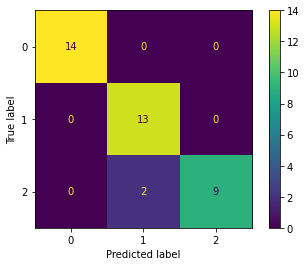

In [10]:
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(test_y, test_pred), display_labels=[0,1,2]).plot();